### Final Data
This notebook is for the final data with data augmentation, resizing and final statistics for the pie plots.

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import shutil
import random
import torchvision.transforms as T
from matplotlib.patches import Rectangle


import torch
SEED = 117
torch.manual_seed(SEED)

In [3]:
def Dataframe_data(root_path):
    """
    Import the csv file from the root_path, and divide into x and y.
    """
    
    # Annotationsdata
    data = pd.read_csv(root_path + 'AnnotationsCollated.csv', delimiter=';', header=None)

    #Delete questionable
    image_type = data.iloc[:,5]

    index_list = []
    for index, row in image_type.iteritems():
        if row == 'Questionable':
            index_list.append(index)
    data = data.drop(index=index_list)
    display(data)

    # Name Dataframe
    names = data.iloc[:,3]
    number = data.iloc[:,4]

    names_concat = pd.concat([names, number], axis=1)
    names_concat.columns = ['Name', 'Number']
    names_concat['Name'] = names_concat['Name'].astype(str) + '_' + names_concat['Number'].astype(str)
    new_name = names_concat.iloc[:,0].values

    # Label Dataframe
    number_of_boxes = data.iloc[:,6]
    box = data.iloc[:,7]
    label_t_l = data.iloc[:,8]
    label_v_a = data.iloc[:,5]
    label_concat = pd.concat([number_of_boxes, box, label_t_l, label_v_a], axis=1)

    return new_name, label_concat


In [4]:
root_path = '/Volumes/T7/ProcessedRequestData/ProcessedData/'
X_b, y_b = Dataframe_data(root_path)

print(len(X_b))
print(len(y_b))

,0,1,2,3,4,5,6,7,8
0,Patient1,Case1,MeasurementSet1,eda1fb4b-0902-4cd1-837c-bddd221fddb6,63,Unknown,0,[],[]
1,Patient1,Case1,MeasurementSet2,ce699728-7891-4af5-bb0c-ce4067f65a89,16,Aorta,1,"[[(2, 26), (232, 527)]]",['T']
2,Patient1,Case1,MeasurementSet3,8b8aa37a-3905-4753-bb0b-f7b7661bc40a,37,Aorta,1,"[[(5, 30), (229, 520)]]",['T']
3,Patient1,Case1,MeasurementSet4,f7f27ea3-b1e5-49e0-ad52-29bb2c4c58f2,37,Unknown,0,[],[]
4,Patient1,Case1,MeasurementSet5,3fc88f9a-11de-4de8-813c-de2095d41eb7,37,Unknown,0,[],[]
...,...,...,...,...,...,...,...,...,...
14741,Patient184,Case1,MeasurementSet1,73c6d87e-a203-4ed7-9342-8b0ff88e2825,31,Unknown,0,[],[]
14742,Patient184,Case1,MeasurementSet2,909bd4a8-f27b-4af2-ae3c-5288db32f1f3,58,Unknown,0,[],[]
14743,Patient184,Case1,MeasurementSet3,60f1babb-72a5-4d62-b966-783caeb6c07d,77,Unknown,0,[],[]
14744,Patient184,Case1,MeasurementSet4,959c8ab2-7426-492a-be16-b02d61f2b0ed,37,Unknown,0,[],[]


13745
13745


In [25]:
def split_data(X_b,y_b):
    """
    Split the data into training, test and validation set.
    """

    # Splitting into training data and test/val data
    seed = 123
    X_train, X_val_test, y_train, y_val_test = train_test_split(X_b,y_b,test_size=0.3, shuffle=True, random_state=seed)

    # Splitting the test data into validation and test data
    seed = 665
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, random_state=seed)

    print('Size of the training dataset: ', len(X_train))
    print('Size of the validation dataset: ', len(X_val))
    print('Size of the test dataset: ', len(X_test))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_b,y_b)

Size of the training dataset:  9621
Size of the validation dataset:  2062
Size of the test dataset:  2062


In [7]:
def class_balance_train(y_train):
    """
    Find the numbers of the different classes in the training set. 
    """
    unknown = 0
    blank = 0
    vessel = 0
    anastomosis = 0
    aorta = 0
    for element in y_train.values:
        if element[3] == "Unknown":
            unknown += 1
        if element[3] == "Blank":
            blank += 1
        if element[3] == "Vessel":
            vessel += 1
        if element[3] == "Anastomosis":
            anastomosis += 1
        if element[3] == "Aorta":
            aorta += 1
    
    print(f"Unknowns: {unknown}, Blanks: {blank}, Vessels: {vessel}, Anastomosis: {anastomosis}, Aorta: {aorta}")

class_balance_train(y_train)

Unknowns: 4588, Blanks: 249, Vessels: 2432, Anastomosis: 1160, Aorta: 1192


In [8]:
def box_labels(label):
    """
    Transform annotation in csv file to a numbers. 
    """   
    # Replace the string with right characters and reshape. 
    box = label[1].replace("(", "").replace("[", "").replace(")", "").replace("]", "").replace(" ", "").split(",")
    box_array = np.array([int(character) for character in box]).reshape(label[0], 4)
            
    return box_array

In [9]:
#Gaussian noise
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [10]:
def resize_image(img, height, width, x1, y1, x2, y2):
    """
    Resize the image and change the bounding boxes. 
    """
    
    if height > width: 
        newsize = (width, 640)
        new_img = img.resize(newsize)

        #Add border
        background = Image.new('RGBA', (640, 640), color="gray")
        offset = (int((640-width)/2), 0)
        background.paste(new_img, offset)

        #Find x1, y1, x2, y2 for new image.
        if height > 640:
            #The height is reduced
            percentage = 1 - (height - 640)/height
            y1_after = y1 * percentage
            y2_after = y2 * percentage
        else: 
            #The height have increased
            percentage = 1 + (640 - height)/height
            y1_after = y1 * percentage
            y2_after = y2 * percentage
        
        gray = (640 - width)/2
        x1_after = x1 + gray
        x2_after = x2 + gray

    else:
        newsize = (640, height)
        new_img = img.resize(newsize)
        
        #Add border
        background = Image.new('RGBA', (640, 640), color="gray")
        offset = (0, int((640-height)/2))
        background.paste(new_img, offset)

        #Find x1, y1, x2, y2 for new image.
        if width > 640:
            #The width is reduced
            percentage = 1 - (width - 640)/width
            x1_after = x1 * percentage
            x2_after = x2 * percentage
        else: 
            #The width have increased
            percentage = 1 + (640 - width)/width
            x1_after = x1 * percentage
            x2_after = x2 * percentage
        
        gray = (640 - height)/2
        y1_after = y1 + gray
        y2_after = y2 + gray

    return background, x1_after, y1_after, x2_after, y2_after

In [11]:
def change_box_array(box_array, img, height, width):
    """
    Change the box array and resize the image. 
    """
    for box_element in box_array:
        x1 = box_element[0]
        y1 = box_element[1]
        x2 = box_element[2]
        y2 = box_element[3]

        resized_image, x1_after, y1_after, x2_after, y2_after = resize_image(img, height, width, x1, y1, x2, y2)

        box_element[0] = x1_after
        box_element[1] = y1_after
        box_element[2] = x2_after
        box_element[3] = y2_after

    return resized_image, box_array


In [12]:
def data_augmentation(X_train,y_train, image_path, crop_pixel):
    """ 
    Do data augmentation and resizing on the the training set. 
    """

    #Dictionary with image name and path to image
    img_dict = {}

    X_split = np.array_split(X_train, 2)
    
    for image, label in zip(X_train, y_train.values):
        #If no object in image, do not augmentate the image
        if label[0] == 0:
            img_dict[image] = f"{image_path}/{image}.png"
            continue
        if label[3] == "Unknown" or label[3] == "Questionable" or label[3] == "Blank":
            img_dict[image] = f"{image_path}/{image}.png"
            continue

        #Add image to dict
        img_dict[image] = f"{image_path}/{image}.png"

        #For every image with an object, do severeal augmentation on the images + fix the labels
        img = Image.open(f'{image_path}/{image}.png')

        #Find height and width of the image
        height = img.height
        width = img.width

        #Bounding boxes of cropped images
        new_box_array = []
        box_array = box_labels(label)
        for box_element in box_array:
            box_element[0] = box_element[0] - crop_pixel/2 #x1
            box_element[2] = box_element[2] - crop_pixel/2 #x2
            box_element[1] = box_element[1] - crop_pixel/2 #y1
            box_element[3] = box_element[3] - crop_pixel/2 #y2 

            box_element = [box_element[0], box_element[1], box_element[2], box_element[3]]
            new_box_array.append(box_element)

        #Crop the images
        crop_img = T.functional.center_crop(img, (int(height - crop_pixel), int(width - crop_pixel)))

        #Either brightness or contrast (50% - 50%)
        if image in X_split[0]:
            aug_img_1 = T.functional.adjust_brightness(crop_img, 1.3)
        else:
            aug_img_1 = T.functional.adjust_contrast(crop_img, 1.3)

        #Either crop or gaussian noise (50% - 50%)
        if image in X_split[0]:
            aug_img_2 = crop_img
        else:
            transform = T.ToTensor()
            aug_img_2 = add_noise(transform(crop_img), 0.3)
            PIL_img = T.ToPILImage()
            aug_img_2 = PIL_img(aug_img_2)

        #Combination of gaussian noise + contrast and gaussian noise + brightness
        if image in X_split[0]:
            transform = T.ToTensor()
            aug_img_3 = add_noise(transform(crop_img), 0.3)
            PIL_img = T.ToPILImage()
            aug_img_3 = PIL_img(aug_img_3)

            aug_img_3 = T.functional.adjust_contrast(aug_img_3, 1.3)
        else:
            transform = T.ToTensor()
            aug_img_3 = add_noise(transform(crop_img), 0.3)
            PIL_img = T.ToPILImage()
            aug_img_3 = PIL_img(aug_img_3)

            aug_img_3 = T.functional.adjust_brightness(aug_img_3, 1.3)

       

        #Save the augmented image to the same path as the original image with name_aug at the end, add do dictionary
        aug_img_1.save(f"{image_path}/{image}_aug_1.png")
        img_dict[f"{image}_aug_1"] = f"{image_path}/{image}_aug_1.png"

        #Make a copy of the label accordingly - save in y
        y_a = y_train
        y_a.reset_index(inplace=True, drop=True)
        y_a.loc[len(y_a.index)] = [label[0], str(new_box_array), label[2], label[3]]

        aug_img_2.save(f"{image_path}/{image}_aug_2.png")
        img_dict[f"{image}_aug_2"] = f"{image_path}/{image}_aug_2.png"

        #Make a copy of the label accordingly - save in y
        y_a.reset_index(inplace=True, drop=True)
        y_a.loc[len(y_a.index)] = [label[0], str(new_box_array), label[2], label[3]]

        aug_img_3.save(f"{image_path}/{image}_aug_3.png")
        img_dict[f"{image}_aug_3"] = f"{image_path}/{image}_aug_3.png"

        #Make a copy of the label accordingly - save in y
        y_a.reset_index(inplace=True, drop=True)
        y_a.loc[len(y_train.index)] = [label[0], str(new_box_array), label[2], label[3]]
        
        
        #Update X and y 
        X_train = np.append(X_train, f'{image}_aug_1')
        X_train = np.append(X_train, f'{image}_aug_2')
        X_train = np.append(X_train, f'{image}_aug_3')
        
    return X_train,y_a, img_dict

In [13]:
#Data augmentation on training set
image_path = "/Volumes/T7/Master/Data_augment/PNGImages_3"

crop_pixel = 50
X_train_a, y_train_a, img_dict  = data_augmentation(X_train,y_train, image_path, crop_pixel)

In [14]:
#Add the images from validation and test into the dictionary
def image_dict(X, y, img_dict, image_path):
    for image, label in zip(X, y.values):
        img_dict[image] = f"{image_path}/{image}.png"
    return img_dict

In [16]:
#Find the class balance of the training set after data augmentation.
class_balance_train(y_train_a)

Unknowns: 4588, Blanks: 249, Vessels: 9692, Anastomosis: 4634, Aorta: 4741


In [29]:
def vessels_per_image(y_train):
    """ 
    Find number of vessels in the dataset.
    """
    number_1 = 0
    number_2 = 0
    number_3 = 0
    number_4 = 0
    number_5 = 0

    for element in y_train.values:
        if element[0] == 1 and element[3]=="Vessel":
            number_1 += 1
        if element[0] == 2 and element[3]=="Vessel":
            number_2 += 1
        if element[0] == 3 and element[3]=="Vessel":
            number_3 += 1
        if element[0] == 4 and element[3]=="Vessel":
            number_4 += 1
        if element[0] == 5 and element[3]=="Vessel":
            number_5 += 1
    
    #print(f"1: {number_1}, 2: {number_2}, 3: {number_3}, 4: {number_4}, 5: {number_5}")

    return number_1, number_2, number_3, number_4, number_5 

number_1_b, number_2_b, number_3_b, number_4_b, number_5_b = vessels_per_image(y_train)
number_1_a, number_2_a, number_3_a, number_4_a, number_5_a = vessels_per_image(y_train_a)
number_1_t, number_2_t, number_3_t, number_4_t, number_5_t = vessels_per_image(y_test)
number_1_v, number_2_v, number_3_v, number_4_v, number_5_v = vessels_per_image(y_val)

#Numbers Before Data Augmentation
number_1 = number_1_b + number_1_t + number_1_v
number_2 = number_2_b + number_2_t + number_2_v
number_3 = number_3_b + number_3_t + number_3_v
number_4 = number_4_b + number_4_t + number_4_v
number_5 = number_5_b + number_5_t + number_5_v

print(f"1: {number_1}, 2: {number_2}, 3: {number_3}, 4: {number_4}, 5: {number_5}")
#Numbers After Data Augmentation
number_1 = number_1_a + number_1_t + number_1_v
number_2 = number_2_a + number_2_t + number_2_v
number_3 = number_3_a + number_3_t + number_3_v
number_4 = number_4_a + number_4_t + number_4_v
number_5 = number_5_a + number_5_t + number_5_v

print(f"1: {number_1}, 2: {number_2}, 3: {number_3}, 4: {number_4}, 5: {number_5}")

1: 2752, 2: 548, 3: 162, 4: 21, 5: 1
1: 8500, 2: 1670, 3: 495, 4: 75, 5: 4


In [18]:
def find_border(x_center, y_center, box_width, box_height, height, width):    
        """ 
        Find bounding box border to be able to plot the images. 
        """
        xmin = (x_center * width) - ((box_width*width)/2)
        ymin = (y_center * height) - ((box_height*height)/2)
        border = Rectangle((xmin, ymin), (box_width * width), (box_height * height), linewidth=1, edgecolor ='red', facecolor = 'none', fill=False) 
        return border

In [19]:
def boundingboxes(box_array, height, width):
    """
    Transform annotations to Yolo annotations.
    """
    for box_element in box_array:

        #If box_width is out of bound with image width
        box_element_width = box_element[2] 
        if box_element[2] > width:
            box_element_width = width
            
        if box_element[2] < 0:
            box_element_width = 0
        if box_element[0] < 0:
            box_element[0] = 0

        x_center = (((box_element_width - box_element[0])/2) + box_element[0])/width
        y_center = (((box_element[3] - box_element[1])/2) + box_element[1])/height
        box_width = (box_element_width - box_element[0])/width
        box_height = (box_element[3] - box_element[1])/height

        if box_element[0] > box_element_width:
            x_center = (((box_element[0] - box_element[2])/2) + box_element_width)/width
            box_width = (box_element[0] - box_element_width)/width

        if box_element[1] > box_element[3]:
            y_center = (((box_element[1] - box_element[3])/2) + box_element[3])/height
            box_height = (box_element[1] - box_element[3])/height
        
        if box_width > 1:
            box_width = 1
        if box_height >1:
            box_height = 1

    return x_center, y_center, box_width, box_height

In [20]:
def box_labels_2(label):
    """
    Transform annotation in csv file to a numbers. 
    """ 
    # Replace the string with right characters and reshape.
    box = str(label[7].values).replace("(", "").replace("[", "").replace(")", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
    box_array = np.array([int(character) for character in box]).reshape(int(label[6]), 4)

    return box_array


In [21]:
def before_after_BB(image_path_orig, image_path_cropped, label_before, label_after):
    """ 
    Plot the images before and after data augmentation
    """
    #For Original image
    img_b = Image.open(image_path_orig)
    height_b = img_b.height
    width_b = img_b.width
    
    box_array_b = box_labels_2(label_before)
    x_center_b, y_center_b, box_width_b, box_height_b = boundingboxes(box_array_b, height_b, width_b)
    border_b = find_border(x_center_b, y_center_b, box_width_b, box_height_b, height_b, width_b)
    
    #For Cropped image
    img_a = Image.open(image_path_cropped)
    height_a = img_a.height
    width_a = img_a.width

    box_array_a = box_labels_2(label_after)
    x_center_a, y_center_a, box_width_a, box_height_a = boundingboxes(box_array_a, height_a, width_a)
    border_a = find_border(x_center_a, y_center_a, box_width_a, box_height_a, height_a, width_a)

    #Plot the figure
    row = 1
    col=2

    plt.figure()
    _, axs = plt.subplots(row, col,)

    axs[0].imshow(img_b)
    axs[0].set_title('Original image')

    axs[1].imshow(img_a)
    axs[1].set_title('Cropped image')

    axs[0].add_patch(border_b)
    axs[1].add_patch(border_a)
    plt.show()

<Figure size 640x480 with 0 Axes>

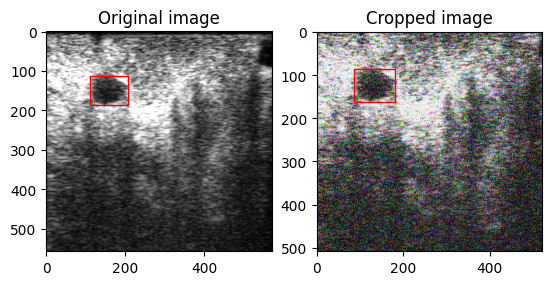

In [22]:
def plot(X_b, y_b, X_a, y_a, image_path):
    """
    Plot the images before and after data augmentation
    """
    X_b = list(X_b)
    X_a = list(X_a)
    index_list = []
    for idx, img_name in enumerate(X_b):
        if f"{img_name}_aug_3" not in X_a:
            continue
        else:
            index_list.append(idx)


    index_image = random.choice(index_list)

    #Find label for image before aug
    img_name = X_b[index_image]
    label_b = y_b.iloc[[index_image]]

    #Find label for image after aug
    idx_a = X_a.index(f'{img_name}_aug_3')
    label_a = y_a.iloc[[idx_a]]

    image_path_b = f"{image_path}/{img_name}.png"
    image_path_a = f"{image_path}/{img_name}_aug_3.png"

    before_after_BB(image_path_b, image_path_a, label_b, label_a)

image_path_1 = "/Volumes/T7/Master/Data_augment/PNGImages_3"
plot(X_b, y_b, X_train_a, y_train_a, image_path_1)
    

In [23]:
def copy_images(X, image_dict, out_path):
    for element in X:
        for key, value in image_dict.items():
            # print(f'This is element {element}, this is key {key}')
            if element == key:
                shutil.copy(value, out_path)

In [24]:
def labels_txt(X, y, data_path, label_path):
    aorta_num = 0
    vessel_num = 0
    anastomosis_num = 0

    for image, label in zip(X, y.values):
        number = label[0]

        if number == 0:
            continue

        if label[3] == "Unknown" or label[3] == "Questionable" or label[3] == "Blank":
            continue
        if label[3] == "Aorta":
            aorta_num += 1
        if label[3] == "Vessel":
            vessel_num += 1
        if label[3] == "Anastomosis":
            anastomosis_num += 1

        # Replace the string with right characters and reshape. 
        box = label[1].replace("(", "").replace("[", "").replace(")", "").replace("]", "").replace(" ", "").split(",")
        box_array = np.array([int(character) for character in box]).reshape(number, 4)

        # Normalize the labels with width and height
        img = Image.open(f'{data_path}/{image}.png')
        height = img.height
        width = img.width

        # Resize image, get new labels out
        resized_image, box_array_after = change_box_array(box_array, img, height, width)
        height = resized_image.height
        width = resized_image.width

        new_array = []
        # Change the labels in right format of the bounding boxes; x_center, y_center, width, height
        x_center, y_center, box_width, box_height = boundingboxes(box_array_after, height, width)
        new_array.append([x_center, y_center, box_width, box_height])


        # Character label
        char_label = label[2].replace("[", "").replace("]", "").replace("'", "").replace(" ", "").replace("T", "0").replace("L", "1").split(",")
        label_array = np.array([int(character) for character in char_label]).reshape(number, 1) 
        
        # Vessel, Anastomosis or Aorta
        type_label = label[3].replace("", "").replace(" ", "").replace("Vessel","2").replace("Anastomosis","3").replace("Aorta","4").split(",")  
        type_array = np.array([np.repeat(int(typ), number) for typ in type_label]).reshape(number, 1)

        #Save the resized image
        resized_image.save(f"{data_path}/{image}.png")

        # write the labelling file
        filename = (f'{image}'+'.txt')
        new_file_path = os.path.join(f'{label_path}/{filename}')
        new_file = open(new_file_path, 'w')

        for label_1, label_2, object in zip(label_array, type_array, new_array):
            new_file.write(f'{label_1[0]}' + ' ')

            for num in object:
                new_file.write(f'{num}' + ' ')
            new_file.write('\n')
            
            new_file.write(f'{label_2[0]}' + ' ')

            for num in object:
                new_file.write(f'{num}' + ' ')
            new_file.write('\n')
        new_file.close()
    return aorta_num, anastomosis_num, vessel_num

In [25]:
#Training Data
TrainingData_path = '/Volumes/T7/Master/Data_augment/Yolov5/Request_da_2/images/train'
traininglabel_path = '/Volumes/T7/Master/Data_augment/Yolov5/Request_da_2/labels/train'
copy_images(list(X_train_a), img_dict, TrainingData_path)
aorta_num_train, anastomosis_num_train, vessel_num_train = labels_txt(X_train_a, y_train_a, TrainingData_path, traininglabel_path)



In [30]:
#Validation Data
ValidationData_path = '/Volumes/T7/Master/Data_augment/Yolov5/Request_da_2/images/val'
validationlabel_path = '/Volumes/T7/Master/Data_augment/Yolov5/Request_da_2/labels/val'
image_path = "/Volumes/T7/Master/Data_augment/PNGImages_3"
img_dict = image_dict(X_val, y_val, img_dict, image_path)

copy_images(list(X_val), img_dict, ValidationData_path)
aorta_num_val, anastomosis_num_val, vessel_num_val = labels_txt(X_val, y_val, ValidationData_path, validationlabel_path)


In [31]:
#Test Data
TestData_path = '/Volumes/T7/Master/Data_augment/Yolov5/Request_da_2/images/test'
testlabel_path = '/Volumes/T7/Master/Data_augment/Yolov5/Request_da_2/labels/test'

image_path = "/Volumes/T7/Master/Data_augment/PNGImages_3"
img_dict = image_dict(X_test, y_test, img_dict, image_path)

copy_images(list(X_test), img_dict, TestData_path)
aorta_num_test, anastomosis_num_test, vessel_num_test = labels_txt(X_test, y_test, TestData_path, testlabel_path)

In [32]:
print(f"Total antall aortas i datasettet: {aorta_num_train + aorta_num_test + aorta_num_val}")
print(f"Total antall Vessel i datasettet: {vessel_num_train + vessel_num_val + vessel_num_test}")
print(f"Total antall anastomosis i datasette: {anastomosis_num_train + anastomosis_num_val + anastomosis_num_test}")

Total antall aortas i datasettet: 5241
Total antall Vessel i datasettet: 10744
Total antall anastomosis i datasette: 5103
